**Workshop**

จงหาสัญญาณซื้อขาย RSI 14 วัน ของหุ้น NVDA โดยดึงข้อมูล Nvidia ในระดับ Daily

## Import data

In [13]:
import yfinance as yf
import mplfinance as mpf
import pandas as pd
import numpy as np
import pandas_ta as ta

In [39]:
# define asset and date
ticker_name = 'NVDA'
start='2019-01-01' 
end='2021-01-01'

In [40]:
raw_df = yf.download(tickers=ticker_name, start=start, end=end)

[*********************100%***********************]  1 of 1 completed


## Strategy

In [41]:
raw_df.ta.rsi(length=14, append=True)

Date
2019-01-02          NaN
2019-01-03          NaN
2019-01-04          NaN
2019-01-07          NaN
2019-01-08          NaN
                ...    
2020-12-24    43.562286
2020-12-28    41.655126
2020-12-29    42.897147
2020-12-30    48.432355
2020-12-31    46.267841
Name: RSI_14, Length: 505, dtype: float64

In [42]:
raw_df

,Open,High,Low,Close,Adj Close,Volume,RSI_14
Date,,,,,,,
2019-01-02,32.660000,34.619999,32.512501,34.055000,33.805470,50875200,NaN
2019-01-03,33.447498,33.790001,31.922501,31.997499,31.763046,70555200,NaN
2019-01-04,32.735001,34.432499,32.424999,34.047501,33.798016,58562000,NaN
2019-01-07,34.625000,36.222500,34.107498,35.849998,35.587315,70916000,NaN
2019-01-08,36.672501,36.695000,34.224998,34.957500,34.701359,78601600,NaN
...,...,...,...,...,...,...,...
2020-12-24,130.372498,131.324997,129.387497,129.937500,129.702820,9788400,43.562286
2020-12-28,130.625000,130.625000,127.632500,129.000000,128.766998,21256400,41.655126
2020-12-29,129.250000,130.725006,128.422501,129.432495,129.198746,17037200,42.897147


In [43]:
raw_df.loc[(raw_df['RSI_14'] > 70) & (raw_df['RSI_14'].shift(1) < 70), 'action'] = 'sell'
raw_df.loc[(raw_df['RSI_14'] < 30) & (raw_df['RSI_14'].shift(1) > 30), 'action'] = 'buy'

## Visualization

In [58]:
# 'col_signal' include buy and sell signal which we have to seperate the signal by our direction (side) that we pay attention.
# 'value' check the signal before add into the list

def mark_ticker(col_signal, col_price, direction):
    signal = []
    for date, value in col_signal.iteritems():
        # long side on DataFrame
        if direction == 'buy':
            if value == 'buy':
                signal.append(col_price[date] * 0.80)
            else:
                signal.append(np.nan)
        # short side on DataFrame
        elif direction == 'sell':
            if value == 'sell':
                signal.append(col_price[date] * 1.20)
            else:
                signal.append(np.nan)
    return signal

/var/folders/6t/_xyw489d5jnd7011n2m_x_ch0000gn/T/ipykernel_21335/586514198.py:6: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for date, value in col_signal.iteritems():


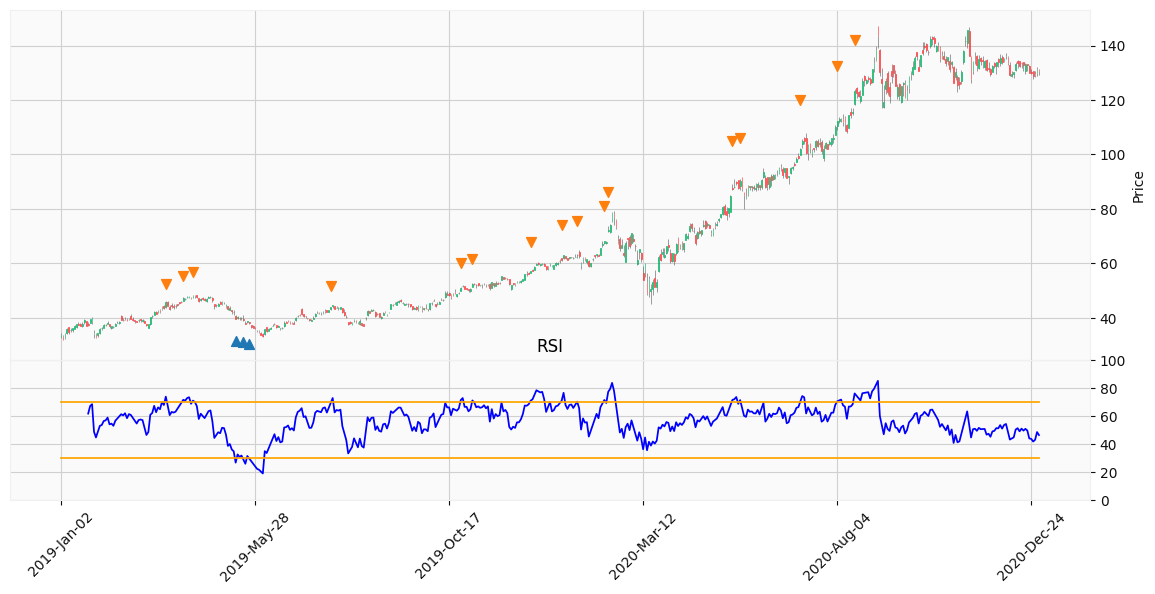

In [59]:
# define for RSI
rsi_ylim = (0,100)
raw_df['upper'] = 70
raw_df['lower'] = 30

viz = [ mpf.make_addplot(mark_ticker(raw_df['action'], raw_df['Close'], 'buy') , type='scatter', markersize=50, marker='^'),
        mpf.make_addplot(mark_ticker(raw_df['action'], raw_df['Open'], 'sell') , type='scatter', markersize=50, marker='v'),
        # RSI
        mpf.make_addplot(raw_df['RSI_14'], panel=1, color='blue', title='RSI', ylim=rsi_ylim),
        mpf.make_addplot(raw_df['upper'], panel = 1, color='orange', ylim=rsi_ylim),
        mpf.make_addplot(raw_df['lower'], panel = 1, color='orange', ylim=rsi_ylim)
        ]

mpf.plot(raw_df, style='yahoo', type='candle', addplot=viz,figsize=(15, 7))

In [60]:
def startegy_return(df, action_price = 'Open', side='long'):
    action_df = df.loc[df['action'].notnull()]

    # action 'Open' (next day)
    if action_price == 'Open':
        action_df['action_price'] = df['Open'].shift(-1)
        action_df['return'] = action_df['action_price'].pct_change()
    
    if action_price == 'Close':
        action_df['action_price'] = df['Close']
        action_df['return'] = action_df['action_price'].pct_change()

    # record df
    record_df = action_df[['action', 'action_price', 'return']]
    record_df.reset_index(inplace=True)
    record_df['previous_signal_date'] = record_df['Date'].shift(1)
    record_df['previous_action'] = record_df['action'].shift(1)
    record_df['previous_action_price'] = record_df['action_price'].shift(1)
    record_df.rename(columns={'Date':'signal_date'}, inplace=True)

    # summary return
    if side == 'long':
        summary_df = record_df[record_df.action == 'sell']
        summary_df
    
    if side == 'short':
        summary_df = record_df[record_df.action == 'buy']
        summary_df['return'] = summary_df['return'] * -1

    summary_df.reset_index(inplace=True, drop=True)    
    
    return df, record_df, summary_df

In [61]:
df, record_df, summary_df = startegy_return(raw_df)

/var/folders/6t/_xyw489d5jnd7011n2m_x_ch0000gn/T/ipykernel_21335/2213148132.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  action_df['action_price'] = df['Open'].shift(-1)
/var/folders/6t/_xyw489d5jnd7011n2m_x_ch0000gn/T/ipykernel_21335/2213148132.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  action_df['return'] = action_df['action_price'].pct_change()
/var/folders/6t/_xyw489d5jnd7011n2m_x_ch0000gn/T/ipykernel_21335/2213148132.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [65]:
record_df[record_df['action'] != record_df['previous_action']]

,signal_date,action,action_price,return,previous_signal_date,previous_action,previous_action_price
0,2019-03-21,sell,45.709999,NaN,NaT,None,NaN
3,2019-05-13,buy,40.012501,-0.167274,2019-04-10,sell,48.049999
6,2019-07-23,sell,44.349998,0.185116,2019-05-22,buy,37.422501


In [66]:
record_df[record_df['action'] != record_df['previous_action']][record_df['action'] == 'sell']

/var/folders/6t/_xyw489d5jnd7011n2m_x_ch0000gn/T/ipykernel_21335/894599703.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  record_df[record_df['action'] != record_df['previous_action']][record_df['action'] == 'sell']


,signal_date,action,action_price,return,previous_signal_date,previous_action,previous_action_price
0,2019-03-21,sell,45.709999,NaN,NaT,None,NaN
6,2019-07-23,sell,44.349998,0.185116,2019-05-22,buy,37.422501


In [68]:
record_df[record_df['action'] != record_df['previous_action']][record_df['action'] == 'sell']['return']

/var/folders/6t/_xyw489d5jnd7011n2m_x_ch0000gn/T/ipykernel_21335/1572425393.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  record_df[record_df['action'] != record_df['previous_action']][record_df['action'] == 'sell']['return']


0         NaN
6    0.185116
Name: return, dtype: float64